# Mass-Spring-Damper Systems
# Second Order in Time with Damping, Non Linearity and Periodic Forcing 
# Harmonic Balancing vs. Time Integration

## Import Libraries

In [1]:
using LinearAlgebra
using NonlinearSolve
using DifferentialEquations
using FFTW

using BenchmarkTools

using Plots 

## Section 1: Introduction  

We study the harmonic balance method and time integration applied to the ODE 

$$ 
m \, \ddot{u}(t) + \gamma \, \dot{u}(t) + k_1 \, u(t) + k_3 \, u^3(t) = F_0 \sin(\omega_d t)
\text{ supplied with }
u(t=0) = u_0 \text{ and } \dot{u}(t=0) = v_0 \, . 
$$ 

The goals **goals** of this notebook include 
1. recap definitions and introduce notation that we employ in the remainder of the project;
2. introduce the <b>sympy</b> package as an additional tool for computations; 
3. introduce the celebrated <b>Duffing equation</b> as an example of a non-linear model with periodic forcing for which reference results are abundantly available in the literature; 

This notebook is structured into the following <b>four</b> parts: 
1. analysis of a linear mass-spring system oscillating endlessly without damping at its natural frequency; 
2. analysis of a linear mass-spring-damper system <b>without</b> periodic forcing oscillating at its natural frequency until the amplitude is negligably small; 
3. analysis of a linear mass-spring-damper system <b>with</b> periodic forcing oscillating oscillating at the frequency of the forcing (thus no longer the natural frequency) after initial effects have been cancelled;
4. analysis of a <b>non-linear</b> mass-spring-damper system with periodic forcing oscillating at a superposition of various frequencies. These frequencies include the frequency of the forcing (base frequency or fundamental frequency) and a set of integer multiples of this base frequency. More precise statements depend on the form of the non-linear term;  

To do:
1. Duffing equation: transient: obtain two solutions depending on the initial guess defined 
1. Duffing equation: time-harmonic: single harmonic: obtain two valleys in the landscape of the mismatch;
1. Duffing equation: time-harmonic: single harmonic: structure of the Jacobian; 
1. Duffing equation: time-harmonic: two harmonics: provide more details - structure of the Jacobian; 
1. Duffing equation: compare transient and HB: first for linear prblem. Perform FFT after transient simulation for various values of the driving frequency. Extract sine and cos mode amplide and compare with HB method; 

##  Section 2:  Case-(1/4): Linear Mass-Spring System (no external forcing, no damping)

<b>Problem Formulation</b> Mass-spring model without damping and without external forcing. Assuming Hooke's linear relation betweeen force and displacement for the spring to hold. Assume non-zero initial position $u_0$ and non-zero initial velocity $v_0$. Then Newton's Law of motion results in the following initial value problem for second order ordinary differential equation 

$$
m \, \ddot{u}(t) + k \, u(t) = 0 \text{ supplied with }
u(t=0) = u_0 \text{ and } \dot{u}(t=0) = v_0 \, . 
$$

<b>Analytical Solution</b> We rewrite the equation in canonical form (coeffient in front of $\ddot{u}(t)$ equal one) as $\ddot{u}(t) + \omega_0^2 \, u(t) = 0$, where $\omega_0 = \sqrt{k/m}$. 

Solve this homogeneous equation by solving first the characteristic equation. Then determine constants of integration using the initial conditions. Solution for $u(t)$ and $v(t)$ are  

$$
u(t) = u_0 \cos(\omega_0 \, t) + v_0 / \omega_0 \sin(\omega_0 \, t) \\
v(t) = - u_0 \, \omega_0 \, \sin(\omega_0 \, t) + v_0 \, \cos(\omega_0 \, t) \, . 
$$

Undamped oscillation occur at eigen (natural or proper) frequency $\omega_0$. For future reference, we rewrite the analytical solution as 
$u(t) = C \, \sin(\omega_0 \, t + \phi)$ where 
$C=\pm \sqrt{u_0^2+(v_0 / \omega_0)^2}$ (mind the physical dimensions) and $\phi = \arctan(v_0/(\omega_0 * u_0))$. FFT analysis show single peak at frequency $f_0 = \omega_0/(2*\pi)$ with peak value equal to $\sqrt{u_0^2+(v_0 / \omega_0)^2}$. The harmonic balance method is exact in this linear case and should give the amplitude of this single harmonic.    

This solution is generated symbolically (using sympy) in the notebook on [analytical and symbolic computations](./analytical_symbolic_computations.ipynb).  

### Define parameters 

In [82]:
#..set initial conditions for position (u0) and velocity (v0)
u0    = 0.1 # 0.1
v0    = 1.0 # 0.0   

#..set frequency and angular frequency 
freq = 0.1
om0  = 2 * π * freq 

#..set array p of parameters 
p = [om0, u0, v0]

#..compute the amplitude for u(t)
Campl = sqrt(u0^2+(v0/om0)^2)
display("Analytically computed position amplitude = "); display(Campl)
display("Analytically computed eigen freq (f0) = "); display(freq)

#..set end time and time interval 
Tend = 100.0 
tspan = (0.0,Tend);

"Analytically computed position amplitude = "

1.5946879290502092

"Analytically computed eigen freq (f0) = "

0.1

### Define analytical solution 

Note in Julia programming: observe the use of broadcast and of reduce(hcat,...) to transform a Vector of Vectors into an array.  

In [83]:
function u_anal(t,p)
    om0, u0, v0 = p 
    result = [-u0*om0*sin(om0*t) + v0*cos(om0*t), u0*cos(om0*t) + v0/om0*sin(om0*t)] 
    return result 
end 

u_anal (generic function with 1 method)

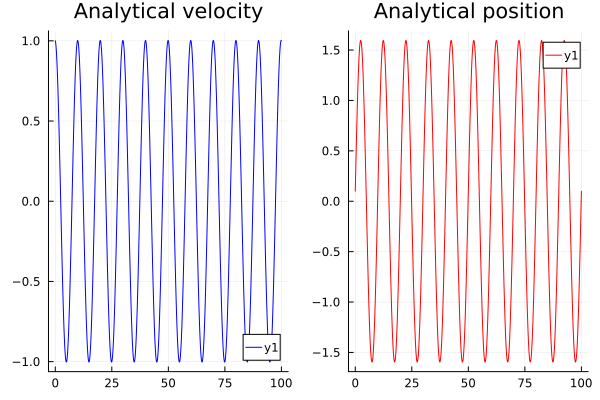

In [84]:
tvec   = Vector(0.:tspan[2]/10000:tspan[2])
result = u_anal.(tvec, Ref(p))
result = reduce(hcat,result)
p1 = plot(tvec, result[1,:],line = :blue,title="Analytical velocity") 
p2 = plot(tvec, result[2,:],line = :red,title="Analytical position") 
plot(p1,p2,layout=(1,2))

### Perform Time Integration and FFT analysis 

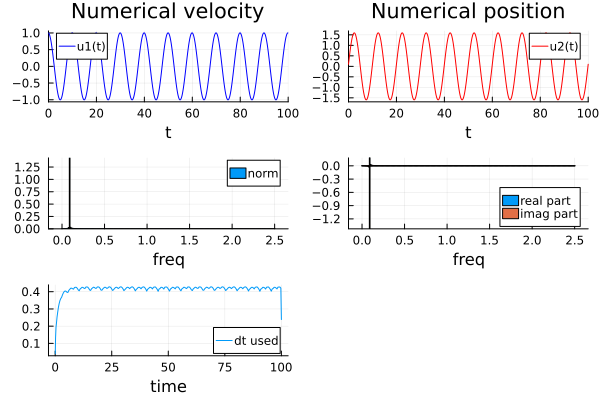

In [85]:
#..set rhs function of the ODE system 
function rhs(du,u,p,t)
    om0, u0, v0 = p 
    ddu = -om0^2*u
end 

#..set problem 
prob = SecondOrderODEProblem(rhs,v0,u0,tspan,p)

#..solve problem 
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8) 

# retrieve velocity and position at specific sampling points 
Tstart = 10 
Nsamples = 500
dt = Tend/Nsamples
tsampled = Vector(Tstart:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]

# perform FFT of sampled position data and appropriately scale the result 
uf = fft(usampled); uf = 2.0/Nsamples * uf 

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)

#..plot computed velocity and position in time  
p1 = plot(sol,idxs=1,line = :blue,title="Numerical velocity")
p2 = plot(sol,idxs=2,line = :red,title="Numerical position")
plot(p1,p2,layout = (1,2))

#..plot absolute value of FFT samples  
p3 = bar(fvec, abs.(uf[1:length(fvec)]),xlabel="freq",label="norm")
p4 = bar(fvec, real.(uf[1:length(fvec)]),xlabel="freq",label="real part")
p4 = bar!(fvec, imag.(uf[1:length(fvec)]),xlabel="freq",label="imag part") 

#..plot the time-step 
dt = sol.t[2:end] - sol.t[1:end-1]
p5 = plot(sol.t[2:end],dt,xlabel="time",label="dt used")

plot(p1,p2,p3, p4,p5, layout = (3,2))

### Compare Analytical and Numerical Approach 

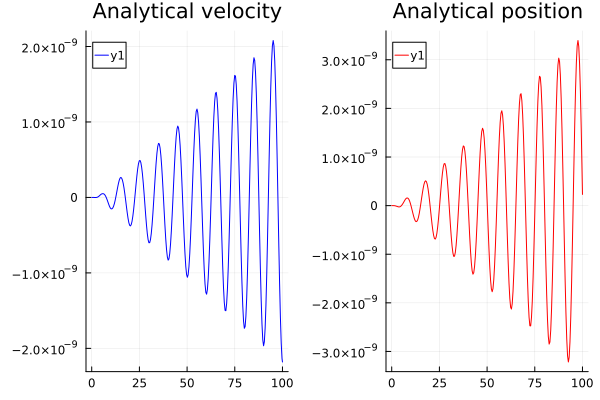

In [9]:
result = u_anal.(sol.t, Ref(p))
result = reduce(hcat,result)
vsampled = [sol(tk,idxs=1) for tk in sol.t] 
usampled = [sol(tk,idxs=2) for tk in sol.t]
p1 = plot(sol.t, result[1,:]-vsampled,line = :blue,title="Analytical velocity") 
p2 = plot(sol.t, result[2,:]-usampled,line = :red,title="Analytical position") 
plot(p1,p2,layout=(1,2))

### Exercises

1. explore the time integration in the time integration as a function of the absolute and relative tolerance imposed; 
2. compare explicit and implicit methods in the time integration (to do: provide more theory for students to understand this); 
3. compare second-order and first order coupled formulations in the time integration (do do: as above);
4. use the macro @btime to benchmark various runs in terms of memory usage and CPU time; 
5. observe in the FFT results, the shift peak location by changing frequency and the change in peak amplitude by changing the initial conditions;
6. extend to non-zero initial velocoity; 
7. make plots of orbits in the phase plane, see [this tutorial](https://docs.sciml.ai/DiffEqDocs/stable/examples/classical_physics/#Second-Order-Linear-ODE) as example; 

## Section 3: Case-(2/4): Linear Mass-Spring-Damper System (no external forcing)

<b>Problem Formulation</b> Linear model, no external forcing, non-zero initial position $u_0$, zero initial velocity. Initial value problem  

$$
m \, \ddot{u}(t) + \gamma \, \dot{u}(t)+ k \, u(t) = 0 \text{ supplied with }
u(t=0) = u_0 \text{ and } \dot{u}(t=0) = v_0 \, . 
$$

Equation in canonical form is $\ddot{u}(t) + \gamma/m \, \dot{u}(t)+ \omega_0^2 \, u(t) = 0$. 

<b>Analytical Solution</b> Solve using the characteristic equation. Solution 
$u(t) = \exp(- \gamma / (2 \, m) \, t) [ u_0 \, \cos(\Omega_0 \, t) + v_0/\Omega_0 \, \sin(\Omega_0 \, t)]$. Damped oscillations apppear. $u(t)$ approaches zero for long times. No oscillations after sufficiently long term. We refer to this case as Case-2 because compares to Case-1, no harmonic information survives. The harmonic balance method should result in a zero solution. 

To do: 
1. explain why numerical integration fails in case that damping factor is too large; 

### Define parameters

In [10]:
#..set initial conditions for position (u0) and velocity (v0)
u0    = 0.1 # 0.1
v0    = 1.0 # 0.0   

#..set frequency and angular frequency 
freq = .1
om0  = 2 * π * freq 
ga   = 0.25 
ma   = 1 

#..set array p of parameters 
p = [om0, ga, ma, u0, v0]

#..compute the amplitude for u(t)
Campl = sqrt(u0^2+(v0/om0)^2)
# display("Amplitude goes to zero for t large")

#..set end time and time interval 
Tend = 20.0 # 10.0 # 100.0 
tspan = (0.0,Tend);

### Define Analytical Solution 

In [11]:
function u_anal(t,p)
    om0, ga, ma, u0, v0 = p
    gascaled = ga/(2*ma)
    om = om0 - gascaled^2
    result = [exp(-gascaled*t)*(-u0*om0*sin(om0*t) + v0*cos(om0*t))-gascaled*exp(-gascaled*t)*(u0*cos(om*t) + v0/om0*sin(om*t)), 
              exp(-gascaled*t)*(u0*cos(om*t) + v0/om0*sin(om*t))] 
    return result 
end 

u_anal (generic function with 1 method)

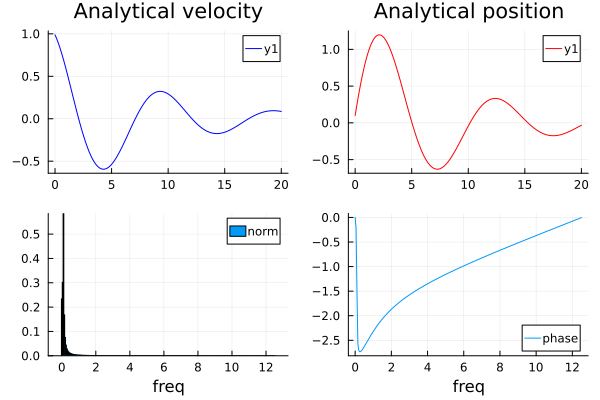

In [12]:
tvec   = Vector(0.:tspan[2]/10000:tspan[2])
result = u_anal.(tvec, Ref(p))
result = reduce(hcat,result)

# retrieve velocity and position at specific sampling points 
Nsamples = 500
Tstart = 20 
dt = Tend/Nsamples
tsampled = Vector(0:dt:Tend)
vsampled = [u_anal(tk,p)[1] for tk in tsampled] 
usampled = [u_anal(tk,p)[2] for tk in tsampled]

# perform FFT of sampled position data 
uf = fft(usampled);

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)

p1 = plot(tsampled, vsampled,line = :blue,title="Analytical velocity") 
p2 = plot(tsampled, usampled,line = :red,title="Analytical position") 

#..plot absolute value of FFT samples  
p3 = bar(fvec, 2.0/Nsamples * abs.(uf[1:length(fvec)]),xlabel="freq",label="norm")
p4 = plot(fvec, angle.(uf[1:length(fvec)]),xlabel="freq",label="phase")

plot(p1,p2,p3, p4, layout = (2,2))

### Perform Numerical Time Integration and FFT Analysis

Observe how in case of damping, the time step increases and error in computed solution decrases as the solution damps. 

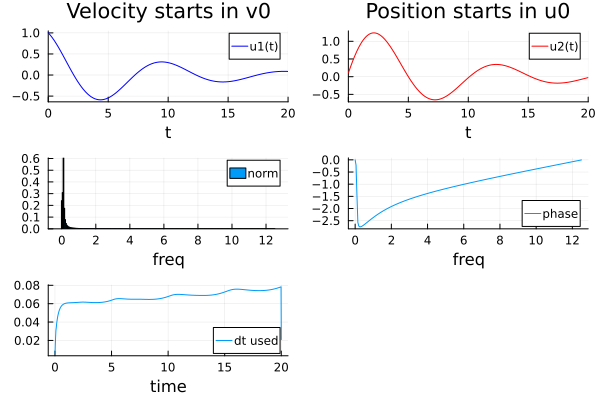

In [13]:
function rhs(du,u,p,t)
    om0, ga, ma, u0, v0 = p 
    ddu = -om0^2*u - ga/ma*du 
end

#..set problem 
prob = SecondOrderODEProblem(rhs,v0,u0,tspan,p)

#..solve problem 
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-14, abstol = 1e-14) 

# retrieve velocity and position at specific sampling points 
Nsamples = 500
Tstart = 20 
dt = Tend/Nsamples
tsampled = Vector(0:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]

# perform FFT of sampled position data 
uf = fft(usampled);

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)

#..plot computed velocity and position in time  
p1 = plot(sol,idxs=1,line = :blue,title="Velocity starts in v0")
p2 = plot(sol,idxs=2,line = :red,title="Position starts in u0")
plot(p1,p2,layout = (1,2))

#..plot absolute value of FFT samples  
p3 = bar(fvec, 2.0/Nsamples * abs.(uf[1:length(fvec)]),xlabel="freq",label="norm")
p4 = plot(fvec, angle.(uf[1:length(fvec)]),xlabel="freq",label="phase")

#..plot the time-step 
dt = sol.t[2:end] - sol.t[1:end-1]
p5 = plot(sol.t[2:end],dt,xlabel="time",label="dt used")

plot(p1,p2,p3, p4,p5, layout = (3,2))

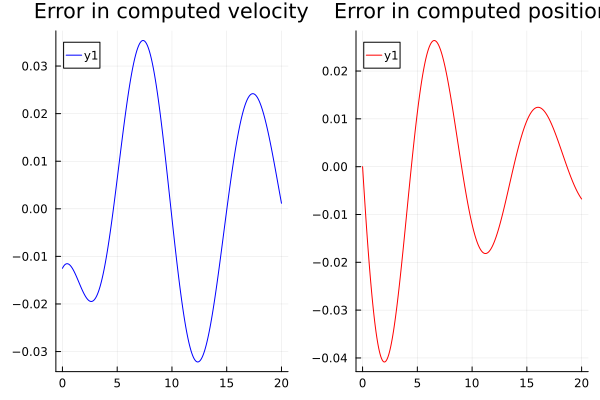

In [14]:
result = u_anal.(sol.t, Ref(p))
result = reduce(hcat,result)
vsampled = [sol(tk,idxs=1) for tk in sol.t] 
usampled = [sol(tk,idxs=2) for tk in sol.t]
p1 = plot(sol.t, result[1,:]-vsampled,line = :blue,title="Error in computed velocity") 
p2 = plot(sol.t, result[2,:]-usampled,line = :red,title="Error in computed position") 
plot(p1,p2,layout=(1,2))

### Exercises 

1. observe in the FFT results, the change in peak amplitude by changing the damping factor; 

## Section 4: Case-(3/4): Linear Mass-Spring-Damper System with Sinusoidal Forcing

<b>Problem Formulation</b> Linear model, non-zero initial position $u_0$, zero initial velocity $v_0=0$. Equation 

$$ 
m \, \ddot{u}(t) + \gamma \, \dot{u}(t)+ k \, u(t) = F_0 \sin(\omega_d t)
\text{ supplied with }
u(t=0) = u_0 \text{ and } \dot{u}(t=0) = v_0 \, , 
$$

where $\omega_d$ denotes the driving frequency (not to be confused with the eigenfrequency $\omega_0$ of the mass-spring-damper system). Observe that we choose a sinusoidal (as opposed to a cosinoidal) forcing and thus a gradual ramping of the forcing.  

<b>Analytical Solution</b> Solution $u(t) = u_h(t) + u_p(t)$ where method of method of variation of constants is used to find $u_p(t)$. Solve 2-by-2 linear system for amplitudes. Details in the notebook on [analytical and symbolic computations](./analytical_symbolic_computations.ipynb).  After long time $u_h(t)=0$ and thus $u(t)=u_p(t)$. Oscillations at frequency $\omega_d$ after sufficiently long term. The amplitude of this oscillation depends on how close $\omega_d$ is to $\omega_0$ (nearness to resonance). The harmonic balance method should find this frequency. 

### Perform Numerical Time Integration and FFT Analysis

"Analytically computed cos amplitude = "

-0.2743269159276652

"Analytically computed sin amplitude = "

1.2927351356404468

"Analytically computed nrm amplitude = "

1.3215216183330898

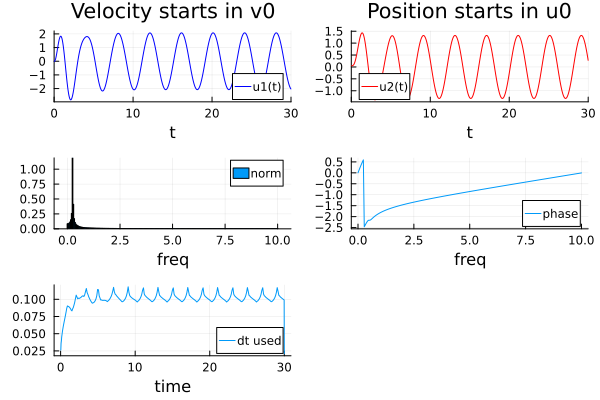

In [86]:
#..set initial conditions for position (u0) and velocity (v0)
u0    = 0.05
v0    = 0.0                        

#..set end time and time interval 
Tend = 30.0 
tspan = (0.0,Tend)  

#..set frequency and angular eigenfrequency and damping coeff
#..set drive amplitude and angular frequency
freq    = .5
omnul   = 2 * π * freq
gamma   = 1 # 10 
omdrive = .5*omnul # try also 10*omnul
Fampl   = 10 
mass    = 1 
p       = [mass, omnul, omdrive, gamma, Fampl];

function rhs(du,u,p,t)
    m, om0, omd, ga, F0 = p
    ddu = -om0^2*u - ga*du + F0*sin(omd*t) 
end

#..compute the amplitude for u(t)
Aampl = -gamma*omdrive*Fampl / (mass^2*(omnul^2-omdrive^2)^2+(gamma*omdrive)^2)
Bampl = mass*(omnul^2-omdrive^2)*Fampl / (mass^2*(omnul^2-omdrive^2)^2+(gamma*omdrive)^2)
Campl = Fampl / sqrt(mass^2*(omnul^2-omdrive^2)^2+(gamma*omdrive)^2)
display("Analytically computed cos amplitude = "); display(Aampl)
display("Analytically computed sin amplitude = "); display(Bampl)
display("Analytically computed nrm amplitude = "); display(Campl)

#..set problem 
prob = SecondOrderODEProblem(rhs,v0,u0,tspan,p)

#..solve problem 
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8) 

# retrieve velocity and position at specific sampling points 
Nsamples = 500
Tstart = 5 
dt = (Tend-Tstart)/Nsamples
tsampled = Vector(Tstart:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]

# perform FFT of sampled position data 
uf = fft(usampled);

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)

#..plot computed velocity and position in time  
p1 = plot(sol,idxs=1,line = :blue,title="Velocity starts in v0")
p2 = plot(sol,idxs=2,line = :red,title="Position starts in u0")
plot(p1,p2,layout = (1,2))

#..plot absolute value of FFT samples  
p3 = bar(fvec, 2.0/Nsamples * abs.(uf[1:length(fvec)]),xlabel="freq",label="norm")
p4 = plot(fvec, angle.(uf[1:length(fvec)]),xlabel="freq",label="phase")

#..plot the time-step 
dt = sol.t[2:end] - sol.t[1:end-1]
p5 = plot(sol.t[2:end],dt,xlabel="time",label="dt used")

plot(p1,p2,p3, p4,p5, layout = (3,2))

### Explore amplitude of cos and sin mode in $u_p(t)$

Here we explore the amplitude in the cosinus and sinus mode in $u_p(t)$. This section is intended as a referenc for later computations. 

In [73]:
# solve linear system for A and B as verification of earlier computations 
AA = [ mass*(omnul^2-omdrive^2) gamma*omdrive; -gamma*omdrive mass*(omnul^2-omdrive^2) ] 
bb = [0 ; Fampl]
amplitudes = AA \ bb 

2-element Vector{Float64}:
 -0.2743269159276652
  1.2927351356404468

In [74]:
function  mismatch(x,p)
    A, B = x 
    m, om0, omd, ga, F0 = p 
    mismathvec = zeros(eltype(x),2)
    mismathvec[1] = m*(om0^2-omd^2)*A + ga*omd*B  
    mismathvec[2] = -ga*omd*A + m*(om0^2-omd^2)*B - F0 
    return mismathvec
end 

mismatch (generic function with 1 method)

In [75]:
# set parameter values 
p = [mass, omnul, omdrive, gamma, Fampl];

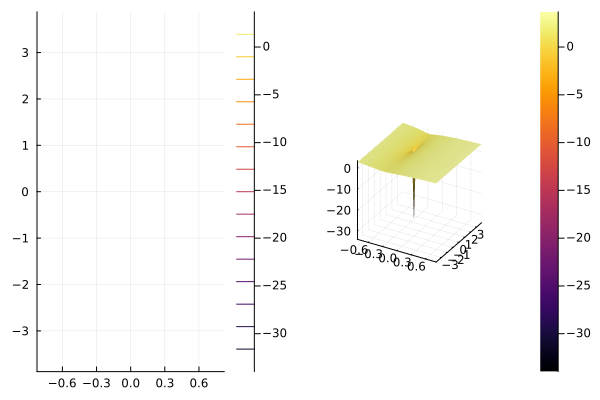

points not sorted in ascending order


In [76]:
xvec = Vector(-3*Aampl:Aampl/10:3*Aampl); yvec = Vector(-3*Bampl:Bampl/10:3*Bampl)
X = [[xi, yj] for xi in xvec, yj in yvec]
M = mismatch.(X,Ref(p))
p1 = contour(xvec, yvec,log.(norm.(M))); p2 = surface(xvec,yvec,log.(norm.(M))) 
plot(p1,p2, layout=(1,2))

In [77]:
prob = NonlinearProblem(mismatch, [0.,0.], p)
solnl = solve(prob, NewtonRaphson())

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


u: 2-element Vector{Float64}:
 -0.2743269159276652
  1.2927351356404468

### Exercises 

1. observe effect of changing $\omega_d$ and the adjustment of the time-step dt to the driving frequency; 

## Section 5: Case-(4/4): Non-Linear Mass-Spring-Damper System with External Forces and Cubic Spring - Duffing Equation - Transient Simulation

<b>Equation to solve</b> Extend previous model with a cubic non-linearity 

$$ 
m \, \ddot{u}(t) + \gamma \, \dot{u}(t) + k_1 \, u(t) + k_3 \, u^3(t) = F_0 \sin(\omega_d t)
\text{ supplied with }
u(t=0) = u_0 \text{ and } \dot{u}(t=0) = v_0 \, . 
$$ 

<b>Important</b> We distinguish two cases depending on the value of $F_0$
1. $F_0$ small enough: the model remains in a linear regime. After initial transients have disappeared due to damping present in the model, the computed solution contains a single frequency. This frequency is equal to the frequency of the excitation. This can shown using FFT. The time step remains large, relative to the case discussed next;  
2. $F_0$ large enough: the model remains in a  goes into a non-linear regine. After initial transients have disappeared, the computed solution contains multiple harmonics. The first frequency is the frequency of the excitation. The other frequencies are multiples of three of this excitation frequency. 

To do: 
1. plot difference of solutions obtained by harmonic balancing and time integration; 

### Perform Numerical Time Integration and FFT Analysis

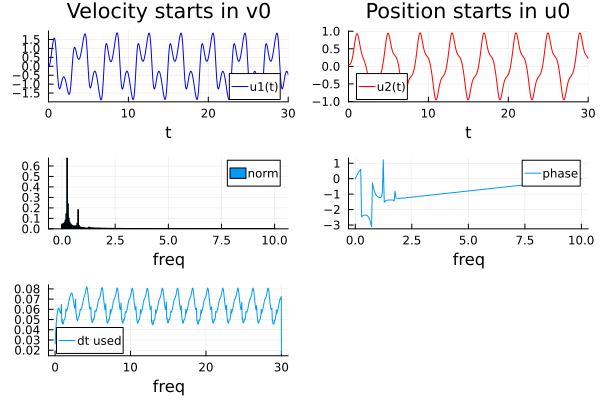

In [138]:
#..set initial conditions for position (u0) and velocity (v0)
u0    = 0.05
v0    = 0.0                        

#..set end time and time interval 
Tend = 30. 
tspan = (0.0,Tend)     

#..set model parameters 
freq      = .5
omnul     = 2 * π * freq
gamma     = 1  
omdrive   = 0.5*omnul 
Fampl     = 10 
mass      = 1 
stiffnlin = 10 
p         = [mass, omnul, omdrive, gamma, stiffnlin, Fampl];

function rhs(du,u,p,t)
    m, om0, omd, ga, stiffnlin, F0 = p
    ddu = -om0^2*u - stiffnlin*u^3 - ga*du + F0*sin(omd*t) 
end

#..set problem 
prob = SecondOrderODEProblem(rhs,v0,u0,tspan,p)

#..solve problem 
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8) 

# retrieve velocity and position at specific sampling points 
Nsamples = 500
Tstart = 5 # 20 
dt = (Tend-Tstart)/Nsamples
tsampled = Vector(Tstart:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]

# perform FFT of sampled position data 
uf = fft(usampled);

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)

#..plot computed velocity and position in time  
p1 = plot(sol,idxs=1,line = :blue,title="Velocity starts in v0")
p2 = plot(sol,idxs=2,line = :red,title="Position starts in u0")

#..plot absolute value of FFT samples  
p3 = bar(fvec, 2.0/Nsamples * abs.(uf[1:length(fvec)]),xlabel="freq",label="norm")
p4 = plot(fvec, angle.(uf[1:length(fvec)]),xlabel="freq",label="phase")

#..plot the time-step 
dt = sol.t[2:end] - sol.t[1:end-1]
p5 = plot(sol.t[2:end],dt,xlabel="freq",label="dt used")

plot(p1,p2,p3, p4,p5, layout = (3,2))

## Section 6: Case-(4/4): Duffing Equation - Time-Harmonic Simulation - Single Harmonic (to edit)

Harmonic balance anzatz at single frequency (same frequency as the driving frequency) 

$$ 
u^{hb}(t) = A \cos(\omega_d t) + B \sin(\omega_d t) 
$$

where the amplitudes $A$ and $B$ are the solution of the third order polynomial system of algebraic equations

$$
m \, (\omega_0^2 - \omega_d^2) \, A + \gamma \, \omega_d \, B 
+ k_3 \, [ \frac{3}{4} \, A^3 + \frac{3}{4} \, A \, B^2 ] = 0 \\
- \gamma \, \omega_d \, A + m \, (\omega_0^2 - \omega_d^2) \, B 
+ k_3 \, [ \frac{3}{4} \, B^3 + \frac{3}{4} \, A^2 \, B ] = F_0 \, . 
$$

To do: 
1. extend with plot comparing harmonic balance method and transient solution in a linear regime; 
1. idem in a non-linear regime; 
1. investigate in case that driving frequency is changed;
1. solve by classical Newton. Inial guess seems to matter. Should we iterate in reverse order? Do we need to supply a Jacobian? Do we need to look into the residual norm? Does solver provide line-searches or trust-region? Do we need to plot the landscape?

In [139]:
function  mismatch(x,p)
    A, B = x 
    m, om0, omd, ga, stiffnlin, F0 = p
    m, om0, omd, ga, stiffnlin, F0 = p 
    mismathvec = zeros(eltype(x),2)
    mismathvec[1] = m*(om0^2-omd^2)*A + ga*omd*B + stiffnlin*.75*(A^3 + A*B^2) 
    mismathvec[2] = -ga*omd*A + m*(om0^2-omd^2)*B + stiffnlin*.75*(B^3 + A^2*B) - F0 
    return mismathvec 
end 

mismatch (generic function with 1 method)

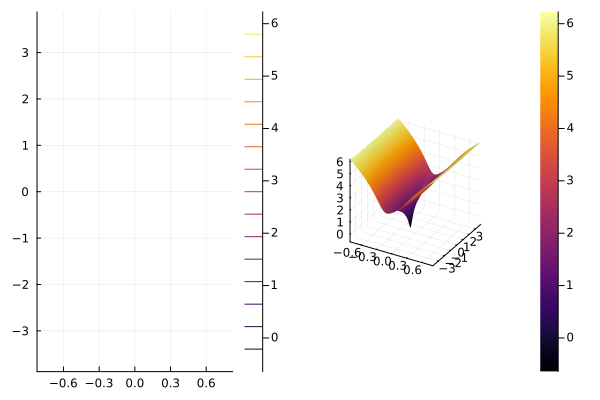

points not sorted in ascending order


In [140]:
xvec = Vector(-3*Aampl:Aampl/10:3*Aampl); yvec = Vector(-3*Bampl:Bampl/10:3*Bampl)
X = [[xi, yj] for xi in xvec, yj in yvec]
M = mismatch.(X,Ref(p))
p1 = contour(xvec, yvec,log.(norm.(M))); p2 = surface(xvec,yvec,log.(norm.(M))) 
plot(p1,p2, layout=(1,2))

In [141]:
prob = NonlinearProblem(mismatch, [Aampl,Bampl], p)
solnl = solve(prob, NewtonRaphson())
display("Computed cos amplitude = "); display(solnl.u[1])
display("Computed sin amplitude = "); display(solnl.u[2])
display("Computed nrm amplitude = "); display(norm(solnl.u))

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


"Computed cos amplitude = "

-0.10234432151344906

"Computed sin amplitude = "

0.8006682511838735

"Computed nrm amplitude = "

0.8071827603460635

In [142]:
function u_hb(t,u,p)
    A, B = u 
    m, om0, omd, ga, stiffnlin, F0 = p
    result = A * cos(omd*t) + B * sin(omd*t)  
    return result 
end 

u_hb (generic function with 1 method)

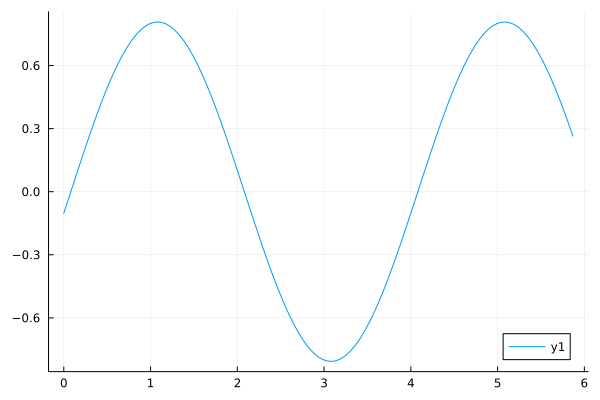

In [143]:
tvec = Vector(0.:tspan[2]/100:tspan[2])
itend = 100
plot(sol.t[1:itend], u_hb.(sol.t[1:itend],Ref(solnl.u), Ref(p)))

1. stiffnlin = 0, then Campl = 1.32 
1. stiffnlin = 1, then Campl = 1.16  
1. stiffnlin = 5, then Campl = 0.92
1. stiffnlin = 10, then Campl = 0.80 

## Section 7: Possible Extensions

1. Extend to include a third order harmonic 
$u^{hb}(t) = A_1 \cos(\omega_d t) + B_1 \sin(\omega_d t) + A_3 \cos(3 \omega_d t) + B_3 \sin(3 \omega_d t)$. This is referred to as the <i>two-frequency ansartz</i> in the [HarmonicBalance.jl package](https://nonlinearoscillations.github.io/HarmonicBalance.jl/stable/); 

2. two coupled masses with positions $u_1(t)$ and $u_2(t)$ (and velocities $v_1(t)$ and $v_2(t)$). Write $u^{hb}(t) = [A_1 \cos(\omega_d t) + B_1 \sin(\omega_d t); A_2 \cos(\omega_d t) + B_2 \sin(\omega_d t)]$ (and similarly for $v^{hb}(t)$). This is referred to as the <i>two coupled oscillators</i> in the [HarmonicBalance.jl package](https://nonlinearoscillations.github.io/HarmonicBalance.jl/stable/); 

3. reformulate as a first order system 
$u^{hb}(t) = A \cos(\omega_d t) + B \sin(\omega_d t)$ and $v^{hb}(t) = C \cos(\omega_d t) + D \sin(\omega_d t)$. This is an intermediate step in solving the shallow water equations as a coupled system of first-order in time equations;    

## References 

1. Duffing equation: [wiki](https://en.wikipedia.org/wiki/Duffing_equation#CITEREFJordanSmith2007): provides details of harmonic balance method for single harmonic.
2. Duffing equation HB single harmonic: [this page](https://euphonics.org/8-2-2-duffings-equation-and-harmonic-balance/) provides an alternative explanastion; 
3. Duffing equation HB single harmonic: see this page [this python solver](https://josephcslater.github.io/mousai/tutorial/demos/Theory_and_Examples.html): interesting perspactive on comparing the harmonic balance method with time-intergration: shows how the unstable branch for solution is not obtained (or reached) using time integration?
4. Harmonic balance method applied to the Duffing equation: [youtube link](https://www.youtube.com/watch?v=4gCx4_RWeS8)
5. Asymptotic Expansions Applied to the Duffing Equation: [youtube link](https://www.youtube.com/watch?v=gxm2AzxfSII) 
6. bifurcartion analysis, eigenvalues of Jacobian, chaotic attractor for the Duffing equation: [Scholarpedia](http://scholarpedia.org/article/Duffing_oscillator)